# Creating a regression model that predicts the writing score using XGBoost

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset = pd.read_csv('StudentsPerformance.csv')

In [253]:
dataset.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


<AxesSubplot:xlabel='parental level of education', ylabel='writing score'>

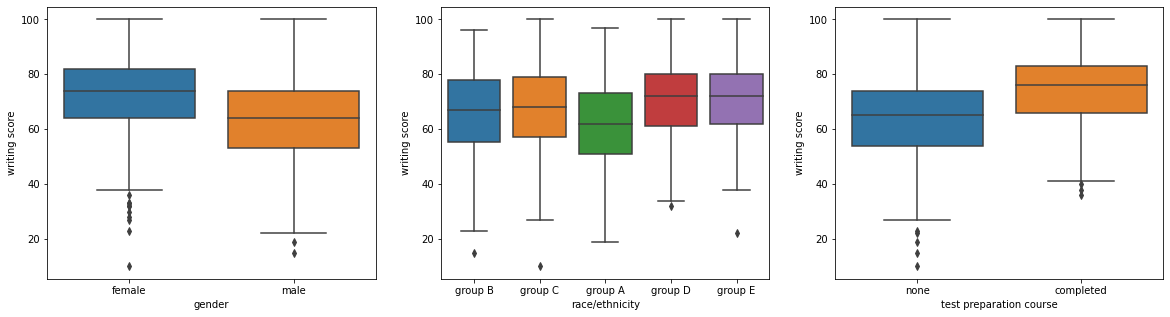

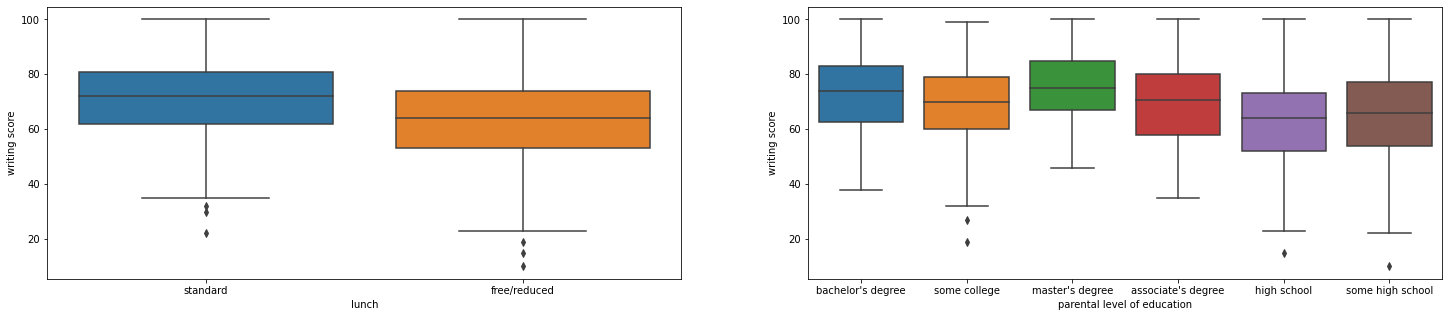

In [254]:
import seaborn as sns
fig,ax = plt.subplots(ncols=3,figsize=(20,5))
sns.boxplot(x='gender',y='writing score',data=dataset,ax=ax[0])
sns.boxplot(x='race/ethnicity',y='writing score',data=dataset,ax=ax[1])
sns.boxplot(x='test preparation course',y='writing score',data=dataset,ax=ax[2])
fig,ax = plt.subplots(ncols=2,figsize=(25,5))
sns.boxplot(x='lunch',y='writing score',data=dataset,ax=ax[0])
sns.boxplot(x='parental level of education',y='writing score',data=dataset,ax=ax[1])


### Here it shows that each of the non test score parameters affect the writing score. It seems that test preparation course and parental level of education plays the biggest part among all five of the parameters. Now we check whether the reading score and math score also affects the writing score.

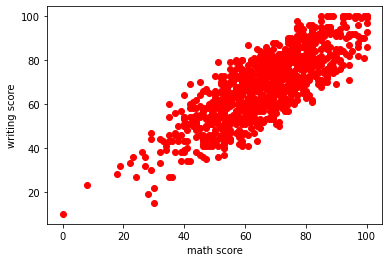

In [255]:
plt.scatter(dataset['math score'],dataset['writing score'],color='red')
plt.xlabel('math score')
plt.ylabel('writing score')
plt.show()

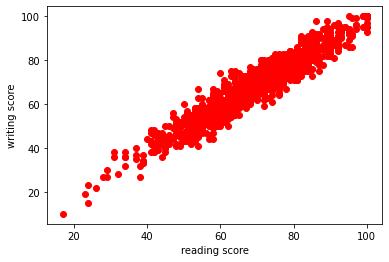

In [256]:
plt.scatter(dataset['reading score'],dataset['writing score'],color='red')
plt.xlabel('reading score')
plt.ylabel('writing score')
plt.show()

### Based on both of the graphs it seems that there is a strong correlation between reading score and math score on the writing score. Based on this we can assume that the students who score well on reading and math test are more academical and thus perform well on their writing test

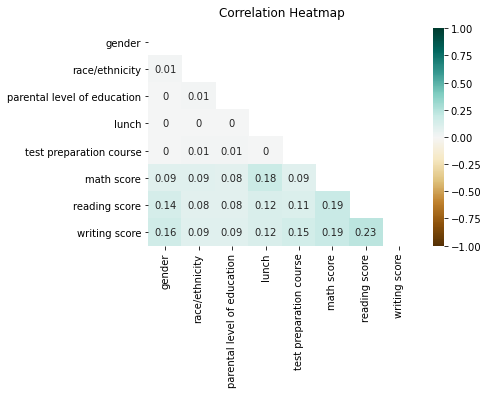

In [257]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
df_categorical_encoded = pd.DataFrame()
for i in dataset.columns:
    df_categorical_encoded[i]=label.fit_transform(dataset[i])

from scipy.stats import chi2_contingency

def cramers_V(var1,var2):
    crosstab = np.array(pd.crosstab(var1,var2,rownames=None,colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return(stat/(obs*mini))
rows =[]

for var1 in df_categorical_encoded:
    col = []
    for var2 in df_categorical_encoded:
        cramers = cramers_V(df_categorical_encoded[var1],df_categorical_encoded[var2])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
cramerv_matrix = pd.DataFrame(cramers_results, columns=df_categorical_encoded.columns,index=df_categorical_encoded.columns)
mask=np.triu(np.ones_like(cramerv_matrix,dtype=np.bool))
cat_heatmap = sns.heatmap(cramerv_matrix,mask=mask,vmin=-1,vmax=1,annot=True,cmap='BrBG')
cat_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12},pad=12);

### The heatmap shows that the most significant parameter to affect the writing score is the reading score. We decide based on the results to use all the other parameters to help in creating the XGBoost model.

In [258]:
X_writing = dataset.drop(['writing score'],axis=1)
y_writing = dataset.iloc[:,-1].values

In [259]:
X_writing.head(n= 100)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
0,female,group B,bachelor's degree,standard,none,72,72
1,female,group C,some college,standard,completed,69,90
2,female,group B,master's degree,standard,none,90,95
3,male,group A,associate's degree,free/reduced,none,47,57
4,male,group C,some college,standard,none,76,78
...,...,...,...,...,...,...,...
95,male,group C,associate's degree,free/reduced,completed,78,81
96,male,group B,some high school,standard,completed,65,66
97,female,group E,some college,standard,completed,63,72
98,female,group D,some college,free/reduced,none,58,67


### We then have to encode the parameters with string values (from gender to test preparation course)

In [260]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse = False), list(range(5)))], remainder='passthrough')
X_writing = np.array(ct.fit_transform(X_writing))

In [261]:
print(X_writing[0:4])

[[ 1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1. 72.
  72.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0. 69.
  90.]
 [ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1. 90.
  95.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1. 47.
  57.]]


### With the string values encoded we can proceed to train our model however we would also like to feature scale the math score and reading score parameter since the value range is rather wide

In [262]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_writing,y_writing,test_size=0.20,random_state=1)

In [263]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:,-2:]=sc.fit_transform(X_train[:,-2:])
X_test[:,-2:]=sc.transform(X_test[:,-2:])

In [264]:
print(X_train[0])

[0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   1.
 0.   0.   1.   0.84 0.82]


### Now we can proceed to creating the XGBoost regression model

In [265]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [266]:
print(X_test)

[[ 0.    1.    0.   ...  1.   -0.76 -0.69]
 [ 1.    0.    0.   ...  1.   -0.42  0.2 ]
 [ 1.    0.    0.   ...  1.   -0.09  0.54]
 ...
 [ 0.    1.    0.   ...  1.    0.84  0.47]
 [ 1.    0.    0.   ...  1.   -0.36 -0.35]
 [ 0.    1.    0.   ...  0.    0.97  0.75]]


In [267]:
print(X_test[0])

[ 0.    1.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    1.   -0.76 -0.69]


In [268]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[ 51.52  54.  ]
 [ 68.98  68.  ]
 [ 73.66  74.  ]
 [ 59.87  58.  ]
 [ 53.93  55.  ]
 [ 53.65  51.  ]
 [ 49.14  51.  ]
 [ 30.72  36.  ]
 [ 66.52  69.  ]
 [ 83.59  82.  ]
 [ 66.52  60.  ]
 [ 56.58  54.  ]
 [ 72.96  67.  ]
 [ 82.52  75.  ]
 [ 70.27  69.  ]
 [ 83.58  84.  ]
 [ 88.74  90.  ]
 [ 92.98  92.  ]
 [ 65.16  63.  ]
 [ 51.22  52.  ]
 [ 84.06  87.  ]
 [ 84.25  84.  ]
 [ 75.99  73.  ]
 [ 58.56  54.  ]
 [ 53.71  50.  ]
 [ 72.15  65.  ]
 [ 69.93  70.  ]
 [ 61.56  68.  ]
 [ 62.24  65.  ]
 [ 68.32  73.  ]
 [ 40.07  48.  ]
 [ 73.07  74.  ]
 [ 48.58  47.  ]
 [ 63.93  68.  ]
 [ 55.98  62.  ]
 [ 84.23  76.  ]
 [ 76.74  72.  ]
 [ 60.37  59.  ]
 [ 61.54  60.  ]
 [ 86.76  93.  ]
 [ 81.19  78.  ]
 [ 75.84  78.  ]
 [ 74.3   74.  ]
 [ 75.23  74.  ]
 [ 82.69  92.  ]
 [ 85.22  89.  ]
 [ 63.29  62.  ]
 [ 67.95  68.  ]
 [ 55.81  49.  ]
 [ 98.53  95.  ]
 [ 73.57  84.  ]
 [ 80.88  82.  ]
 [ 73.39  73.  ]
 [ 77.64  79.  ]
 [ 80.9   81.  ]
 [ 50.55  47.  ]
 [ 78.46  80.  ]
 [ 81.91  76.  ]
 [ 48.88  56. 

In [272]:
print(X_test.shape)
print(regressor.predict((X_test[1:2])))

(200, 19)
[68.98]


### Here is the result of the model against the test set, based on the results the model is rather accurate at predicting the scores

In [270]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9316554389985017

In [271]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 91.59 %
Standard Deviation: 1.48 %


### Our r2 score is 93% while the cross valuation score is at 91.59% at a standard deviation of 1.48%. This means that the confidence level is above 90%